In [1]:
# This notebook creates a test dataset with 2 sources.
# A single time series is derived from an actual photometry experiment
# The emission spectra are simulated as two gaussians with different means.
# This is an easy problem, and this notebook is used to develop and test nmf-based recipes on it.

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from rich import print as pprint
from sourcesep.utils.config import load_config
from aind_ophys_utils.dff import dff

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

In [2]:
# These are combined responses of autofluorescence, Ca sensor (EGFP), and DA sensor (mApple).

from sourcesep.sim import SimData

paths = load_config(dataset_key="all")
sim = SimData(T=100, cfg_path=paths["root"] / "sim_HSFP_670128_2023-04-27.toml")
_ = sim.get_S()
_ = sim.get_W()
_ = sim.get_E()
pprint(sim.W_df)

Paths are for dataset tagged: all
Paths are for dataset tagged: all


405     445     473     514     560
EGFP  0.1732  0.3915  0.8143  0.1469  0.0054

In [3]:
paths = load_config(dataset_key="all")
f = h5py.File(paths["root"] / "HSFP_670128_2023-04-27_data_preprocessed.hdf5", "r")
print(f.keys())

xj = {}
for j in np.argsort(f["Lasers"][:]):
    xj[j] = f[f"Channel{j+1}"][:].astype(float)

t = f["Time"][:]
l = f["Wavelength"][:]
lasers = f["Lasers"][:][np.argsort(f["Lasers"][:])]

print(f"\nsampling frequency: {1/(np.max(t) / t.size):0.2f} Hz")
print(f"length of recording: {np.max(t)-np.min(t):0.2f} seconds")
print(f"\neach channel has dimensions of {xj[0].shape}")
print(f"min. wavelength: {np.min(l):0.2f} nm")
print(f"max. wavelength: {np.max(l):0.2f} nm")

Paths are for dataset tagged: all
<KeysViewHDF5 ['Channel1', 'Channel2', 'Channel3', 'Channel4', 'Channel5', 'Lasers', 'Time', 'Wavelength']>

sampling frequency: 23.99 Hz
length of recording: 448.23 seconds

each channel has dimensions of (10752, 300)
min. wavelength: 400.00 nm
max. wavelength: 699.00 nm


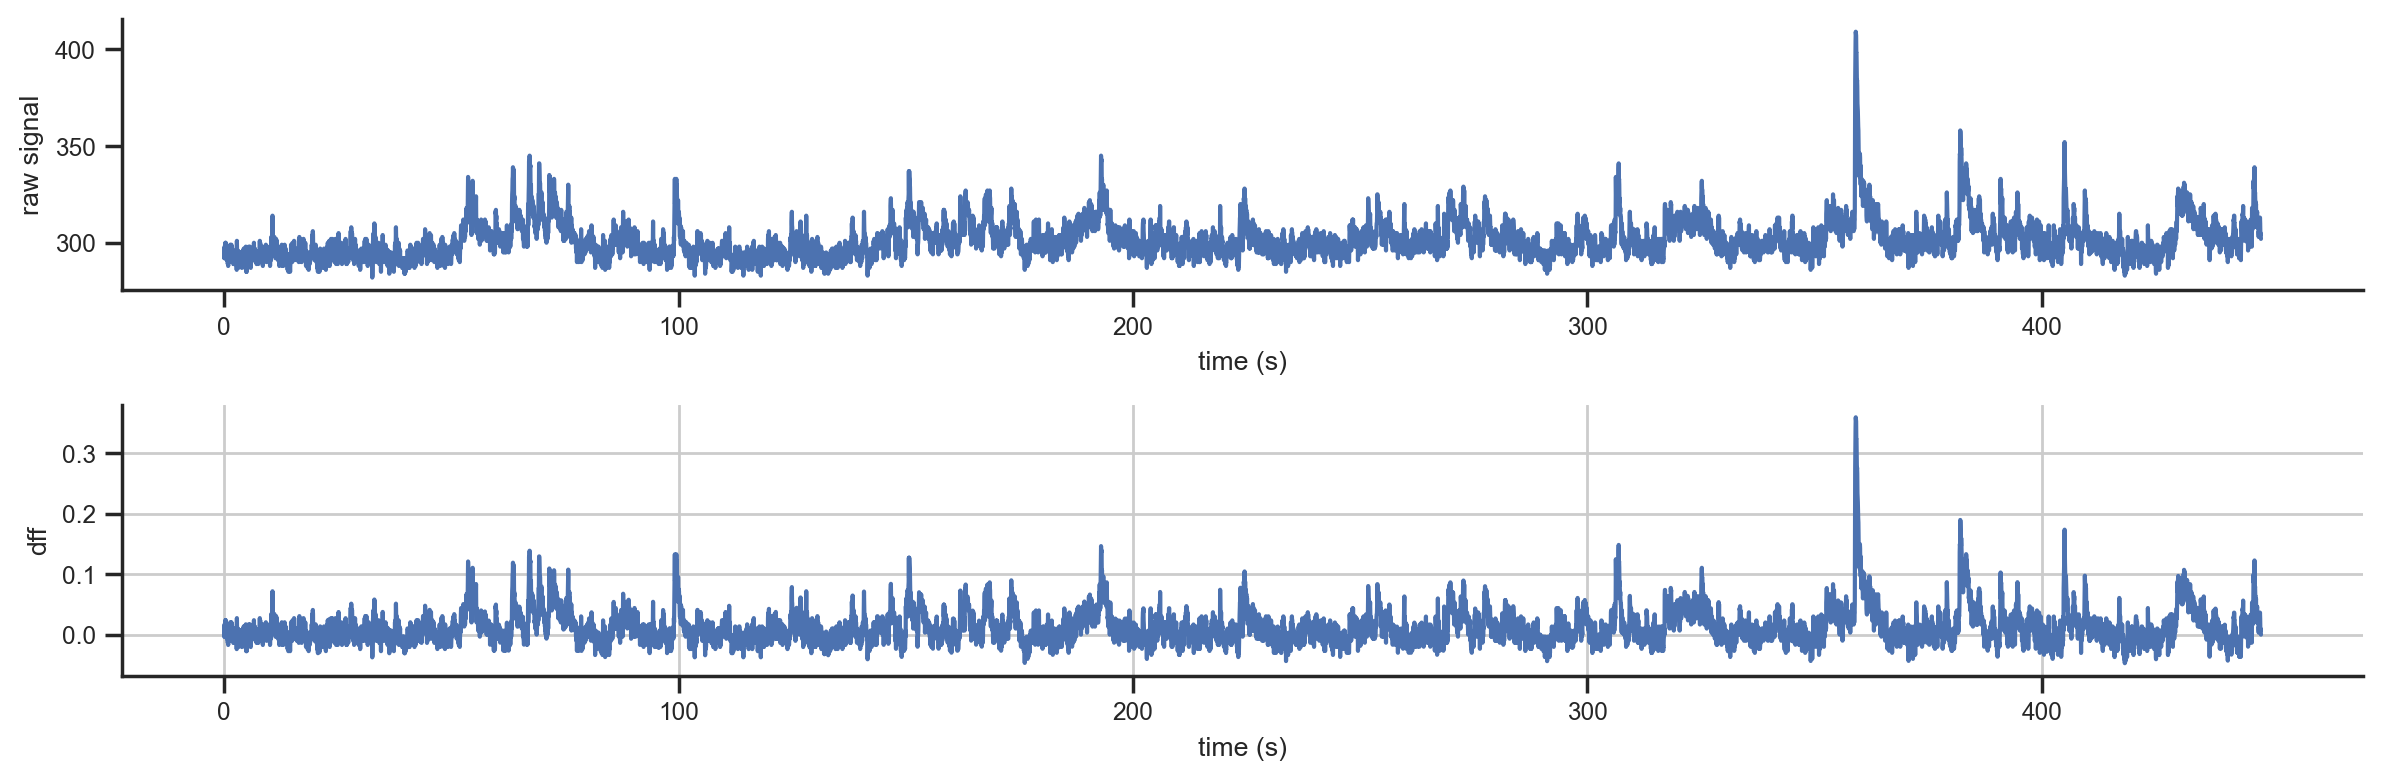

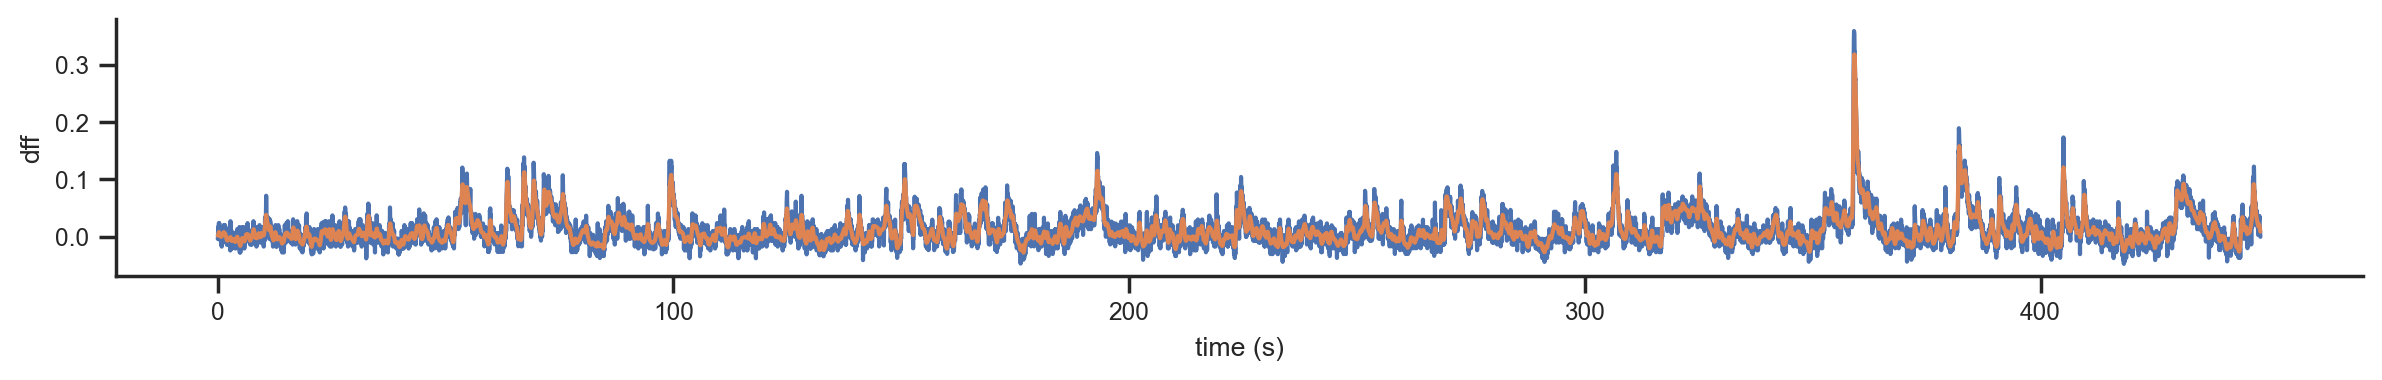

In [4]:
# an example with dff from aind ophys utils
dff_signal, _, signal_sd = dff(xj[2][:, 150], fs=23.99, long_window=20.0, short_window=2.0, inactive_percentile=5)
f, ax = plt.subplots(2, 1, figsize=(12, 4))
ax[0].plot(t, xj[2][:, 150])
ax[1].plot(t, dff_signal)
ax[1].grid(visible=True)
ax[0].set(xlabel="time (s)", ylabel="raw signal")
ax[1].set(xlabel="time (s)", ylabel="dff")
plt.tight_layout()
plt.show()


# smooth the df/f signal with a gaussian filter
from scipy.ndimage import gaussian_filter1d

dff_signal_smooth = gaussian_filter1d(dff_signal, sigma=3)
dff_signal_smooth = dff_signal_smooth[::-1]

f, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.plot(t, dff_signal)
ax.plot(t, dff_signal_smooth[::-1])
ax.set(xlabel="time (s)", ylabel="dff")
plt.tight_layout()
plt.show()

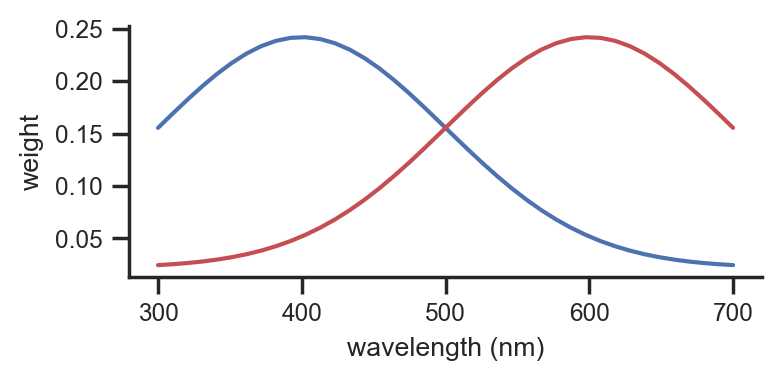

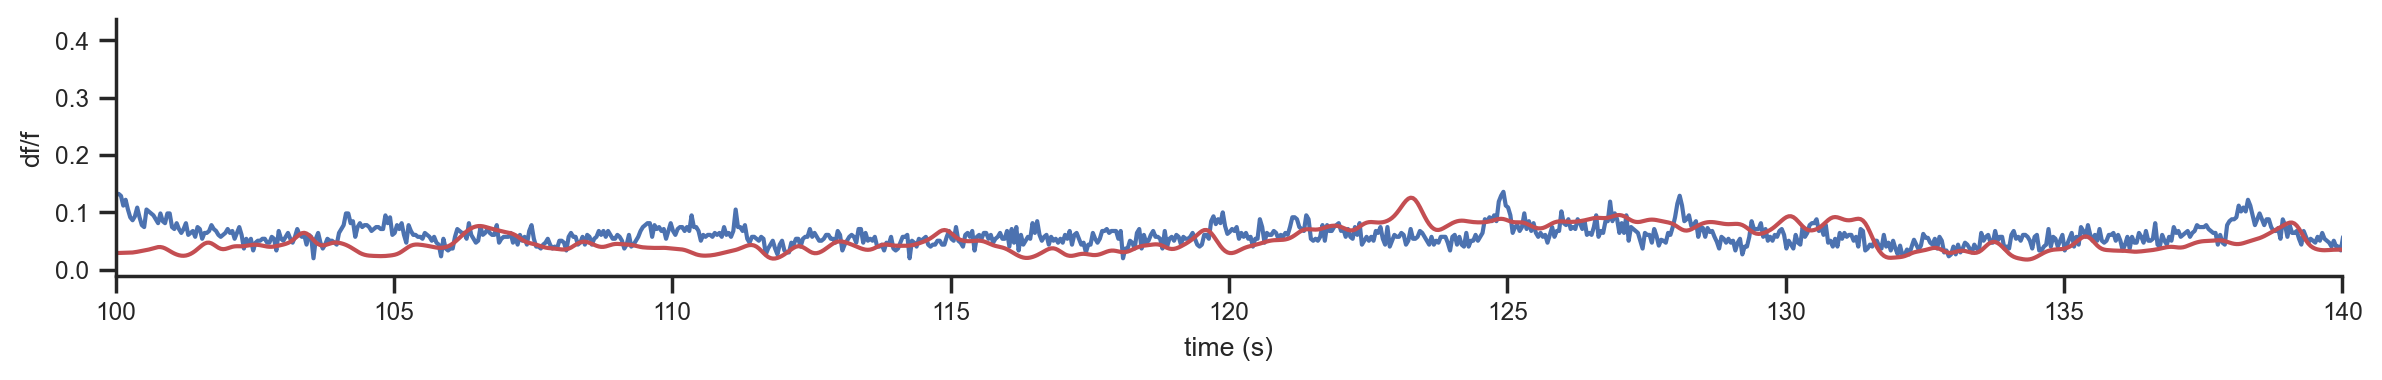

In [5]:
from scipy.stats import norm

l = np.linspace(300, 700, 40)

w1 = norm.pdf(l, loc=400, scale=100)
w1 = w1 / np.max(w1) + 0.1
w1 = w1 / np.linalg.norm(w1)

w2 = norm.pdf(l, loc=600, scale=100)
w2 = w2 / np.max(w2) + 0.1
w2 = w2 / np.linalg.norm(w2)

f, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(l, w1, c="b")
ax.plot(l, w2, c="r")
ax.set(xlabel="wavelength (nm)", ylabel="weight")
plt.tight_layout()
plt.show()

x1 = dff_signal
x2 = dff_signal_smooth
x1 = x1 + np.abs(np.min(x1)) + 1e-2
x2 = x2 + np.abs(np.min(x2)) + 1e-2

f, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.plot(t, x1, c="b")
ax.plot(t, x2, c="r")
ax.set(xlabel="time (s)", ylabel="df/f", xlim=(100, 140))
plt.tight_layout()
plt.show()

In [6]:
X = np.vstack([x1, x2])
A = np.vstack([w1, w2])
A = A.T

print(A.shape)
print(X.shape)

(40, 2)
(2, 10752)


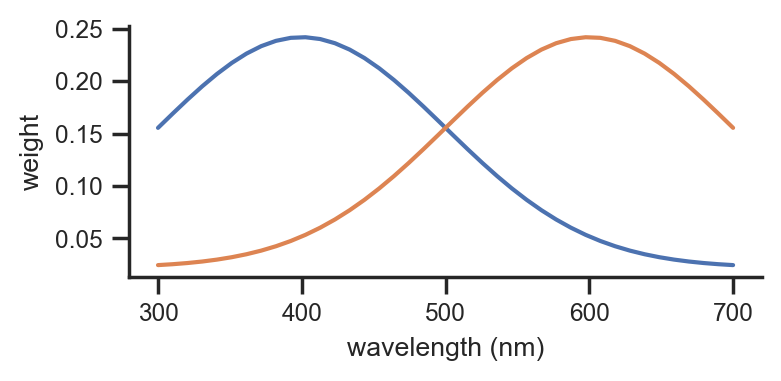

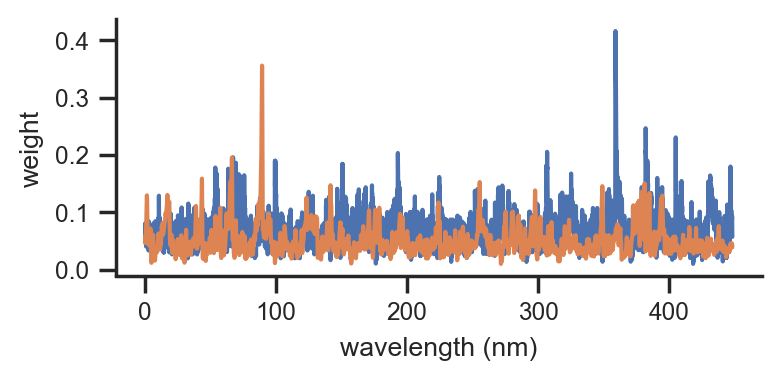

/home/rohan/Local/code/sourcesep/data/sims/nmf_test_01.pkl


In [7]:
f, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(l, A)
ax.set(xlabel="wavelength (nm)", ylabel="weight")
plt.tight_layout()
plt.show()

f, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(t, X.T)
ax.set(xlabel="wavelength (nm)", ylabel="weight")
plt.tight_layout()
plt.show()

Y = A @ X

fname = paths["root"] / "sims" / "nmf_test_01.pkl"
print(fname)

import pickle

with open(fname, "wb") as f:
    pickle.dump({"l": l, "t": t, "Y": Y, "A": A, "X": X}, f)

In [8]:
%autoreload 2
# This notebook focusses on using all the channels to try and get a better estimate on the single indicator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from rich import print as pprint
from sourcesep.utils.config import load_config
from sourcesep.models.nmf_variants import nmf_recipe_01, set_norm

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

import pickle


def plot_AH_sep(dat, res, mpl):
    mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=["b", "c"])
    f, ax = plt.subplots(2, 2, figsize=(10, 4))

    ax[0, 0].plot(dat["l"], dat["A"])
    ax[0, 0].set(xlabel="wavelength (nm)", ylabel="weight")

    ax[0, 1].plot(dat["t"], dat["X"].T)
    ax[0, 1].set(xlabel="time (s)", ylabel="weight")

    ax[1, 0].plot(dat["l"], res["A"])
    ax[1, 0].set(xlabel="wavelength (nm)", ylabel="weight")

    ax[1, 1].plot(dat["t"], res["X"].T)
    ax[1, 1].set(xlabel="time (s)", ylabel="weight")

    plt.tight_layout()
    plt.show()
    return


def plot_AH_mix(dat, res, mpl, tlim=(0, 140)):
    mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=["b", "r"])

    f, ax = plt.subplots(2, 2, figsize=(10, 4))
    ax[0, 0].plot(dat["l"], dat["A"][:, 0])
    ax[0, 0].plot(dat["l"], res["A"][:, 0], alpha=0.5)
    ax[0, 0].set(xlabel="wavelength (nm)", ylabel="weight")

    ax[0, 1].plot(dat["t"], dat["X"].T[:, 0])
    ax[0, 1].plot(dat["t"], res["X"].T[:, 0] + 0.04, alpha=0.8)
    ax[0, 1].set(xlabel="time (s)", ylabel="weight", xlim=tlim)

    ax[1, 0].plot(dat["l"], dat["A"][:, 1])
    ax[1, 0].plot(dat["l"], res["A"][:, 1], alpha=0.5)
    ax[1, 0].set(xlabel="wavelength (nm)", ylabel="weight")

    ax[1, 1].plot(dat["t"], dat["X"].T[:, 1])
    ax[1, 1].plot(dat["t"], res["X"].T[:, 1] + 0.02, alpha=0.8)
    ax[1, 1].set(xlabel="time (s)", ylabel="weight", xlim=tlim)

    plt.tight_layout()
    plt.show()
    return

Paths are for dataset tagged: all


 10%|█         | 1009/10000 [00:06<00:56, 158.36it/s]


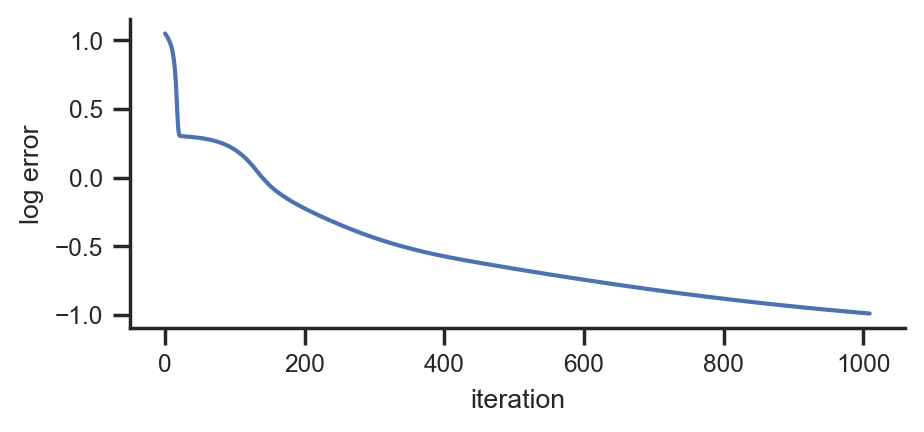

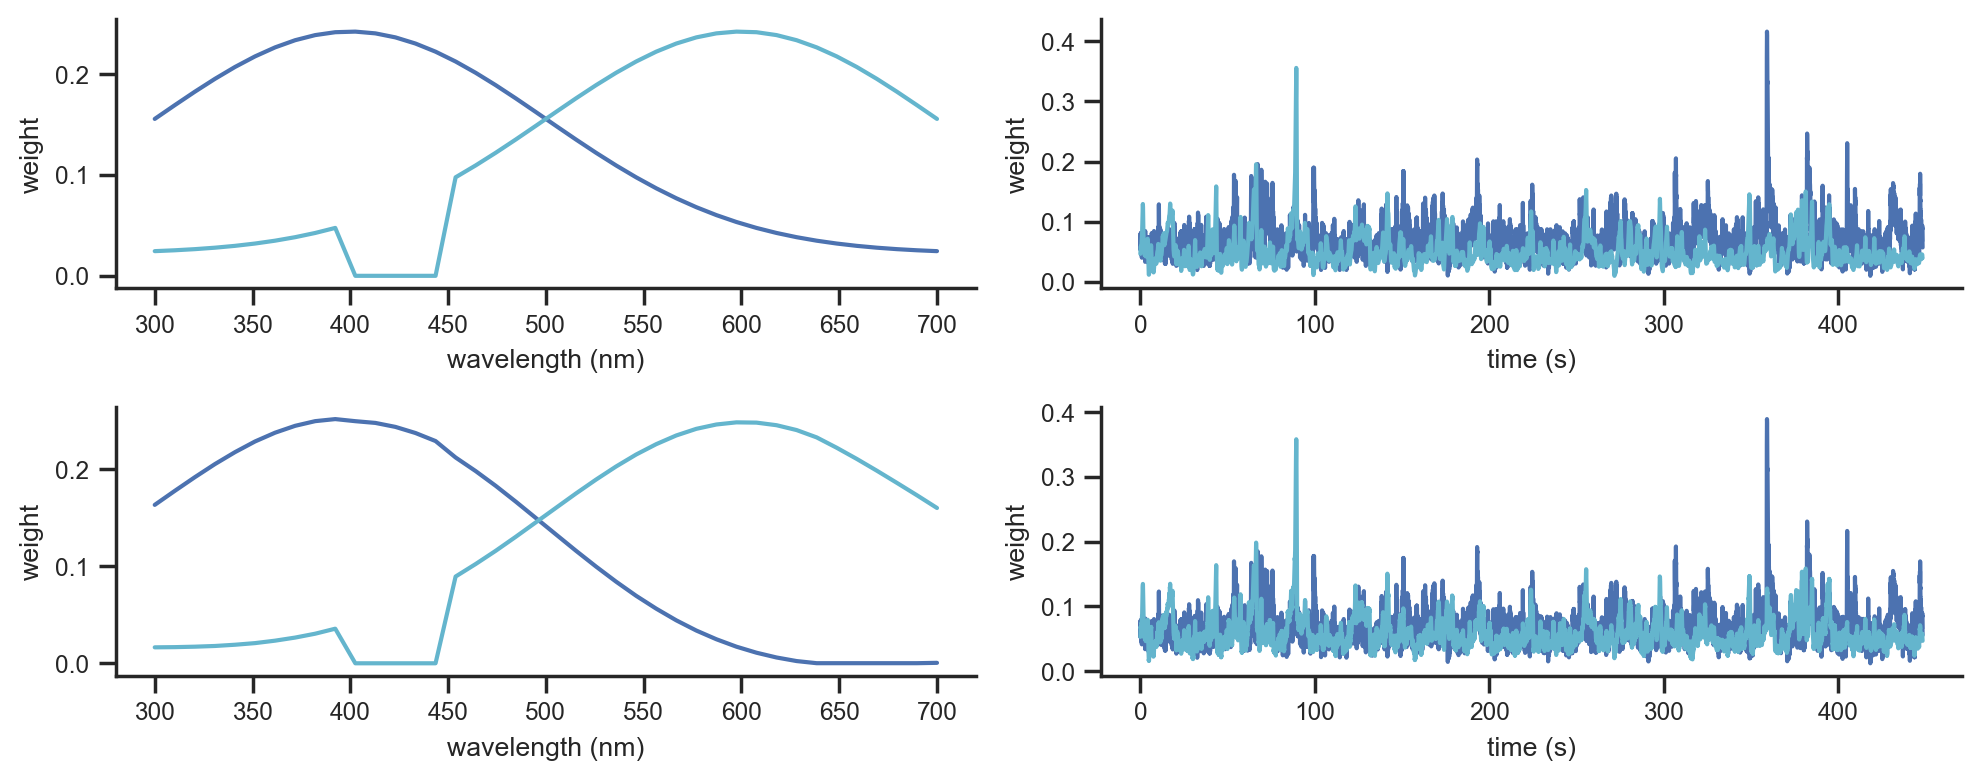

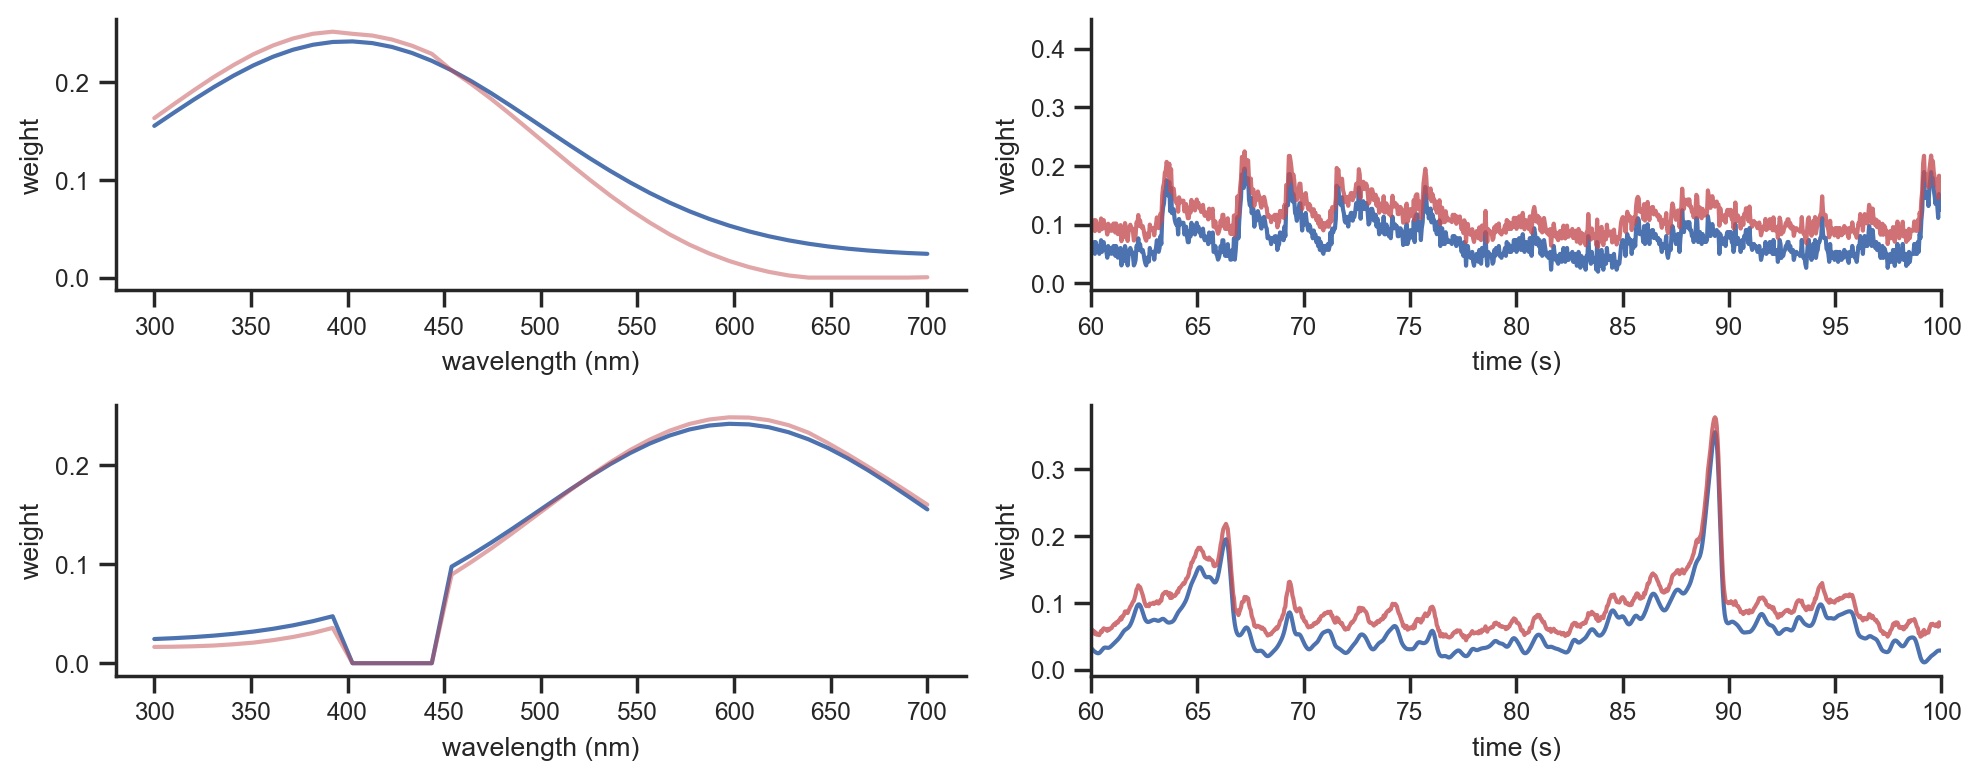

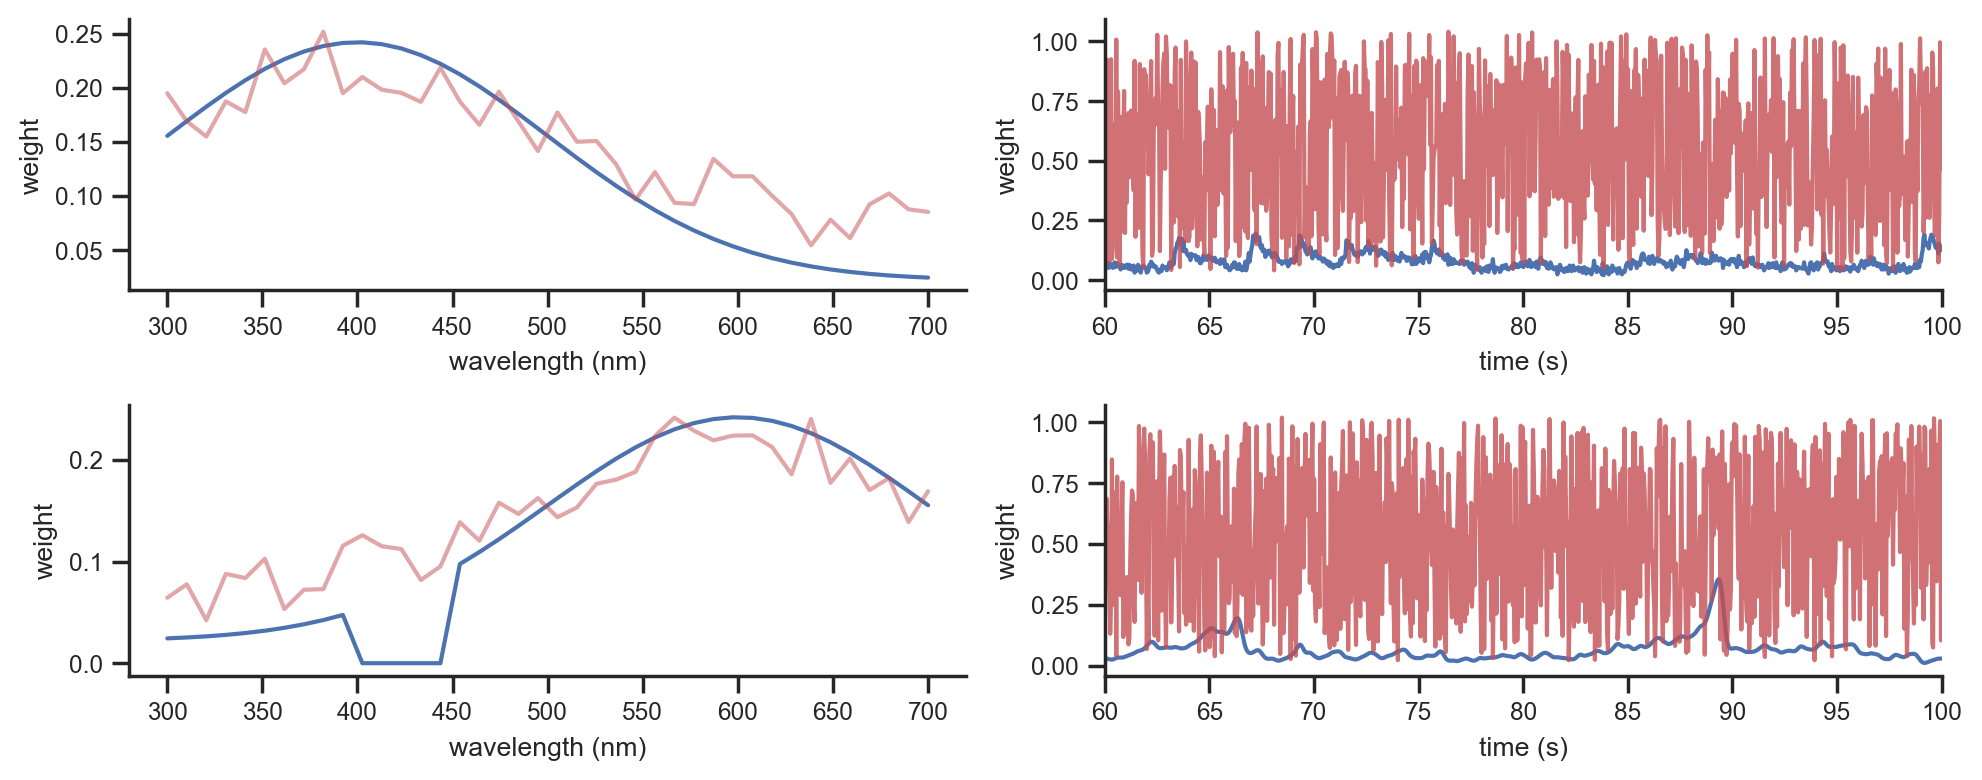

In [9]:
paths = load_config(dataset_key="all")
fname = paths["root"] / "sims" / "nmf_test_01.pkl"
with open(fname, "rb") as f:
    dat = pickle.load(f)

A_init = dat["A"].copy() + 0.1 * np.random.rand(*dat["A"].shape)
A_init = A_init + np.min(A_init) + 1e-2
A_init, _ = set_norm(A_init, axis=0, c=1.0)

ind = np.logical_and(dat["l"] >= 400, dat["l"] <= 450)
dat["A"][ind, 1] = 0
A_keep = dat["A"] > 0
dat["Y"] = dat["A"] @ dat["X"]

A, X, err, init = nmf_recipe_01(
    dat["Y"].copy(),
    A=A_init,
    X=None,
    rank=2,
    A_keep=A_keep,
    X_keep=None,
    grad_type=None,
    step_size_A=0.01,
    step_size_X=0.01,
    lam_2norm_x=0.01,
    lam_deviation_x=0.01,
    tol=1e-4,
    exit_tol=1e-4,
    max_iter=10000,
)

res = {"A": A, "X": X, "err": err}

f, ax = plt.subplots(1, 1, figsize=(5, 2))
ax.plot(np.log10(res["err"]))
ax.set(xlabel="iteration", ylabel="log error")
plt.show()

tlim = (60, 100)

plot_AH_sep(dat, res, mpl)
plot_AH_mix(dat, res, mpl, tlim)
plot_AH_mix(dat, init, mpl, tlim)

In [10]:
# Notes:
# NMF variants:
# HALS
# Poisson NMF

# For multiple indicators, convolutive NMF seems like it would naturally incorporate laser on-off sequence.
# See also SliceTCA

# Caveats:
# The separation is in frequency domain
# df/f eliminates the color spectrum information (this is what we have priors on in the multi-indicator case).
# we have a pretty good starting point (when the color space is not too crowded)